In [18]:
from __future__ import division
import numpy as np
from numpy import fft
from scipy import signal, ndimage, misc, fftpack
import bitarray
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import reedsolo

pylab.rcParams['figure.figsize'] = (20.0, 7.0)
%matplotlib inline

In [19]:
IMG_DIR = 'Images/'

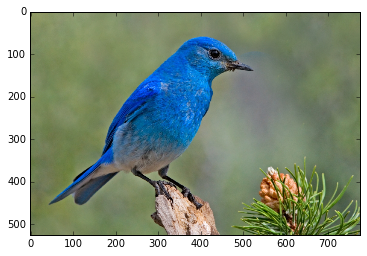

In [20]:
img = ndimage.imread(IMG_DIR+'bird.jpg')
plt.imshow(img)
plt.show()

In [21]:
def RGB2YCbCr(RGB):
    # Full range RGB/YCbCr conversion
    A = np.array([[[ 0.299,  0.587,  0.114],
                   [-0.169, -0.331,  0.500],
                   [ 0.500, -0.419, -0.081]]])
    
    YCbCr = np.dot(A, RGB.reshape((-1, 3)).T).T.reshape(RGB.shape) + np.array([0, 128, 128]).reshape((1,1,3))
    return YCbCr[:,:,0], YCbCr[:,:,1], YCbCr[:,:,2]

def YCbCr2RGB(y, cb, cr):
    # Full range RGB/YCbCr conversion
    B = np.array([[1.000,  0.000,  1.400],
                  [1.000, -0.343, -0.711],
                  [1.000,  1.765,  0.000]])
    
    YCbCr = np.dstack((y, cb-128, cr-128))
    return np.dot(B, YCbCr.reshape((-1, 3)).T).T.reshape(YCbCr.shape)

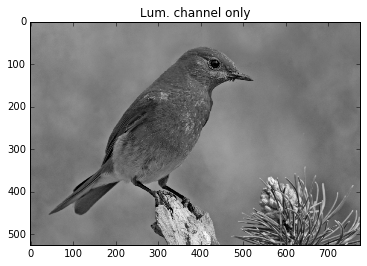

(525L, 775L)


In [22]:
imgL, imgCb, imgCr = RGB2YCbCr(img)
plt.imshow(imgL, cmap='gray')
plt.title("Lum. channel only")
plt.show()

print imgL.shape

In [23]:
def genZigZag(n):
    # Ascending
    swap = 0
    for idxSum in range(n):
        x = 0 if swap else idxSum
        y = idxSum if swap else 0
        if swap:
            while y >= 0:
                yield (x, y)
                x, y = x+1, y-1
        else:
            while x >= 0:
                yield (x, y)
                x, y = x-1, y+1
        swap ^= 1
    
    #Decending
    floor = 1
    for idxSum in range(n, 2*n-1):
        x = floor if swap else n-1
        y = n-1 if swap else floor
        if swap:
            while y >= floor:
                yield (x, y)
                x, y = x+1, y-1
        else:
            while x >= floor:
                yield (x, y)
                x, y = x-1, y+1
        swap ^= 1
        floor += 1

In [24]:
def DCT_2D(x):
    return fftpack.dct(fftpack.dct(x, norm='ortho', axis=0), norm='ortho', axis=1)

def IDCT_2D(x):
    return fftpack.idct(fftpack.idct(x, norm='ortho', axis=0), norm='ortho', axis=1)

In [206]:
x = np.random.randint(0, 255, (8,8)).astype(np.uint8)
xt = DCT_2D(x)
xq = np.divide(xt, JPEG.QL)
xq = np.round(xq)
xq = xq.astype(np.int16)
xr = np.multiply(xq, JPEG.QL)
xo = IDCT_2D(xr)

# print np.linalg.norm(x - xo)/8
print x

[[ 12 248  46 217   1  54 137 111]
 [ 73  49   2 147  80 208  96 103]
 [243  53  14 218  90 226  46  72]
 [124 239  47 120  47 145  14   5]
 [ 71  49   8 219  62 169  68 162]
 [ 63  52 181 148 249 124 232  26]
 [153  38 162 196  43  35  32  79]
 [155 161 163 247 169  11 206  16]]


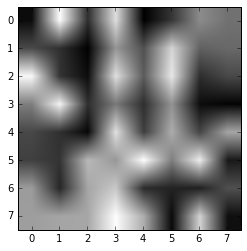

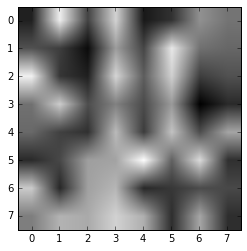

[[ -2.11054755e+01   9.64436646e+00  -2.13927012e+01   6.80977941e+00
   -2.44257749e+01   3.74032800e+00  -8.18637961e+00  -4.96082113e+00]
 [ -7.96148020e+00  -1.31232109e+01  -9.38583686e+00  -9.71649171e+00
    9.67418983e+00  -2.37535015e+01  -1.83227799e+01   2.37142028e-02]
 [  2.53966846e+00  -1.22237816e+00  -1.92801102e+01   4.56589311e+00
   -3.28950603e+00   1.79254628e+01  -1.65786204e+01  -1.00443965e+01]
 [  9.76219352e+00   3.41156245e+01  -3.10563633e+01  -9.20629644e+00
   -2.83744840e+01  -9.20935756e+00   1.40000000e+01  -3.68503008e+01]
 [ -3.40629569e+01  -1.57553774e+01  -4.07491191e+01   3.26230807e+01
    8.44322834e-01  -2.62095154e+01  -9.16943129e+00  -2.48706989e+00]
 [  2.09191731e+01  -1.99958380e+01   2.18512526e+01  -1.48411683e+01
   -6.00000000e+00   2.70818171e+01   1.28214768e+01  -2.37005014e+01]
 [ -5.00487623e+01  -1.14067287e+00   1.38192834e+00   1.43115521e+01
    1.44604319e+00  -2.15124646e+01  -4.27921533e+01   5.59912299e+00]
 [  2.9485498

In [239]:
j = JPEG(x, JPEG.QL)
j.process()

jI = JPEG(j.compressed, JPEG.QL, dims=x.shape, rescale=True)
jI.unprocess()
xo = jI.reconstructed

plt.figure()
plt.imshow(x, cmap='gray')
plt.figure()
plt.imshow(xo, cmap='gray')
plt.show()

print x-xo

In [259]:
class JPEG(object):
    QL = np.array([[16, 11, 10, 16,  24,  40,  51,  61],
                   [12, 12, 14, 19,  26,  58,  60,  55],
                   [14, 13, 16, 24,  40,  57,  69,  56],
                   [14, 17, 22, 29,  51,  87,  80,  62],
                   [18, 22, 37, 56,  68, 109, 103,  77],
                   [24, 35, 55, 64,  81, 104, 113,  92],
                   [49, 64, 78, 87, 103, 121, 120, 101],
                   [72, 92, 95, 98, 112, 100, 103, 99]])
    
    QC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],
                   [18, 21, 26, 66, 99, 99, 99, 99],
                   [24, 26, 56, 99, 99, 99, 99, 99],
                   [47, 66, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99],
                   [99, 99, 99, 99, 99, 99, 99, 99]])
    
    
    def __init__(self, img, qtable, QF=50, dims=None, rescale=False):
        assert 1 <= QF < 100, "Quality Factor (QF) must be 1 <= QF < 100"
        if QF > 50:
            alpha = 2 - QF/50
        else:
            alpha = 50/QF
        
        self.raw = img
        self.qtable = qtable*alpha
        self.dims = img.shape if dims is None else dims
        self.zstride = list(genZigZag(8))
        self.linstride = list(range(64))
        self.rescale = rescale
        
        # Forward path - attributes used in compression
                                    # Original image shape: NxM
        self.transformed = None     # shape: NxM
        self.quantized = None       # shape: NxM
        self.flattened = None       # shape: (N*M/64)x64
        self.compressed = None      # shape: ???
        
        # Reverse path - attributes used in decompression
                                    # Original data shape: ???
        self.decompressed = None    # shape: (N*M/64)x64
        self.expanded = None        # shape: NxM
        self.rectified = None       # shape: NxM
        self.reconstructed = None   # shape: NxM
        
    def process(self):
        self.DCTBlocks()
        self.quantizeBlocks()
        self.flattenBlocks()
        self.compress()
        return self.compressed
    
    def unprocess(self):
        self.decompress()
        self.expandBlocks()
        self.rectifyBlocks()
        self.IDCTBlocks()
        if self.rescale:
            self.rescaleImg()
        return self.reconstructed
    
    def rescaleImg(self, inarr=None):
        if inarr is None:
            inarr = self.reconstructed
        minval = np.min(self.reconstructed)
        if minval < 0:
            self.reconstructed -= minval
        
        maxval = np.max(self.reconstructed)
        if maxval > 255:
            self.reconstructed = np.divide(self.reconstructed, maxval)*255

    def DCTBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.raw
        out = np.zeros(self.dims)
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                out[i:i+8, j:j+8] = DCT_2D(block)

        self.transformed = out
    
    def IDCTBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.rectified
        out = np.zeros(self.dims)
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                out[i:i+8, j:j+8] = IDCT_2D(block)

        self.reconstructed = out
        
    def quantizeBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.transformed
        out = np.zeros(self.dims)
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                out[i:i+8, j:j+8] = np.round(np.divide(block, self.qtable))
                
        self.quantized = out
    
    def rectifyBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.expanded
        out = np.zeros(self.dims)
        
        for i in xrange(0, self.dims[0], 8):
            for j in xrange(0, self.dims[1], 8):
                block = inarr[i:i+8, j:j+8]
                out[i:i+8, j:j+8] = np.multiply(block, self.qtable)
                
        self.rectified = out
        
    def flattenBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.quantized
        nBlocks = (self.dims[0]//8, self.dims[1]//8)
        out = np.zeros((nBlocks[0]*nBlocks[1], 64))
    
        for bx in xrange(nBlocks[0]):
            for by in xrange(nBlocks[1]):
                for i, z in zip(self.linstride, self.zstride):
                    out[nBlocks[1]*bx+by, i] = inarr[bx*8+z[0], by*8+z[1]]
                    
        self.flattened = out
    
    def expandBlocks(self, inarr=None):
        if inarr is None:
            inarr = self.decompressed
        nBlocks = (self.dims[0]//8, self.dims[1]//8)
        out = np.zeros(self.dims)

        for bx in xrange(nBlocks[0]):
            for by in xrange(nBlocks[1]):
                for i, z in zip(self.linstride, self.zstride):
                    out[bx*8+z[0], by*8+z[1]] = inarr[nBlocks[1]*bx+by, i]
                    
        self.expanded = out
        
    def compress(self, inarr=None):
        self.compressed = self.flattened.astype(np.int16)
    
    def decompress(self, inarr=None):
        self.decompressed = self.raw

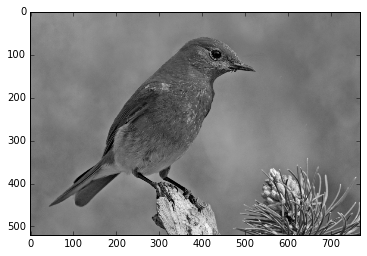

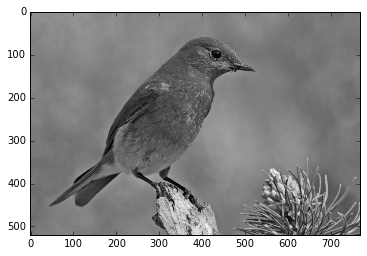

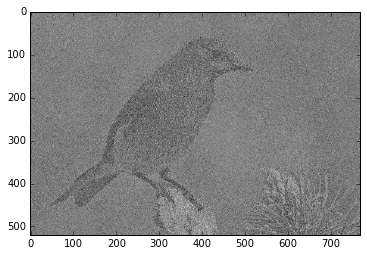

0.0 255.0
0.0 255.0
55 1152
-363 406


In [263]:
imgIn = imgL[:520,:768]

j = JPEG(imgIn, qtable=JPEG.QL, QF=95)
imgProc = j.process()
jI = JPEG(imgProc, JPEG.QL, QF=95, dims=imgIn.shape, rescale=True)
imgOut = jI.unprocess()


plt.figure()
plt.imshow(imgIn, cmap='gray')
plt.figure()
plt.imshow(imgOut.astype(np.uint8), cmap='gray')
plt.figure()
plt.imshow(imgIn - imgOut, cmap='gray')
plt.show()

print np.min(imgIn), np.max(imgOut)
print np.min(imgOut), np.max(imgOut)
print np.min(imgProc[:,0]), np.max(imgProc[:,0])
print np.min(imgProc[:,1:]), np.max(imgProc[:,1:])

In [121]:
import Encoding

In [46]:
reload(Encoding)
testing = j.flattened

# jank solution for bounding values
# DCValues = testing[:, 0]
# ACValues = DCT[:,1:]
# testing = (testing.astype('float64')/np.max(testing) * 1022.0).astype('int')

print Encoding.huffmanLookupChrominanceDC
inspect = Encoding.DCPM(testing[:, 0] )
e = Encoding.encode(testing, Encoding.huffmanLookupChrominanceDC, Encoding.huffmanLookupChrominanceAC)


[[424  -1   2 ...,   0   0   0]
 [415   0   1 ...,   0   0   0]
 [421  -3  -1 ...,   0   0   0]
 ..., 
 [343  31  74 ...,   0   0   0]
 [292  19  68 ...,   0   0   0]
 [229   8 115 ...,   0   0   0]]
{0: '00', 1: '01', 2: '10', 3: '110', 4: '1110', 5: '11110', 6: '111110', 7: '1111110', 8: '11111110', 9: '111111110', 10: '1111111110', 11: '11111111110', 12: '111111111110'}


IndexError: index -1 is out of bounds for axis 0 with size 0

In [42]:
# print testing.shape[0] * testing.shape[1]*8
# print len(e)
# print np.where(inspect == 2098)
t = testing[:, 1:]
print np.max(t)

1228.0


In [31]:
reload(Encoding)
d = Encoding.decode(e)